In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy import integrate
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import os, time, warnings
warnings.filterwarnings('ignore')

Z:\Software\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


### ODEs

In [3]:
def ODEs(data, t, alpha, beta, gamma, delta):
    x, y = data[0], data[1]
    dxdt = alpha*x - beta*x*y
    dydt = delta*x*y - gamma*y
    return [dxdt, dydt]

In [4]:
def errors_ODE(params, data, t, efun = 'RMSE', indexdata = 'full'):
    arr = np.array([data[0][0], data[1][0]])
    
    if indexdata == 'full':
        x, y = np.arange(0, len(t)), np.arange(0, len(t))
        
    else:
        x, y = indexdata[0], indexdata[1]
    
    pred = integrate.odeint(ODEs, arr, t, args=tuple(params))
    
    if efun == "RMSE":
        xerr = mean_squared_error(pred[x,0], data[0], squared = False)
        yerr = mean_squared_error(pred[y,0], data[0], squared = False)
        errors = np.mean([xerr, yerr])
    else:
        xerr = mean_absolute_error(pred[x,0], data[0], squared = False)
        yerr = mean_absolute_error(pred[y,0], data[0], squared = False)
        errors = np.mean([xerr, yerr])
    return errors

### Hill climbing

In [5]:
def hillclimbing(func, data, t, params00 = (0,0,0,0), efun = 'RMSE', iterations = 1000, stepsize = 0.5, indexdata = 'full'):
    est_params = params00
    try: est_eval = func(params00, data, t, efun ,indexdata=indexdata)
    except ValueError: est_eval = 100
    eval_list = [est_eval]
    for iter in range(iterations):
        new_params = np.array(est_params) + np.random.uniform(-1,1,len(params00))*stepsize
        new_params[new_params < 0] = 0
        new_params[new_params > 10] = 10

        try: new_eval  = func(new_params,data,t,efun,indexdata=indexdata)
        except ValueError: new_eval = 100
        if new_eval <= est_eval:
            est_params, est_eval = new_params, new_eval
        eval_list.append(est_eval)
    return (est_eval, est_params, eval_list)

### Simulated Annealing

In [6]:
def simulated_annealing(func, data, t, params00 = (0,0,0,0), efun = 'RMSE', stepsize=0.25,
                        temp_range=(10**0,10**-3), iterations = 1000, cooling = 'quadratic', n_inner = 50, indexdata = 'full'):

    temp_start = temp_range[0]
    temp_end = temp_range[1]
    if cooling == 'exponential':
        rate = (temp_end / temp_start) ** (1 / (iterations/n_inner - 1))
    elif cooling == 'linear':
        rate = (temp_start - temp_end)/(iterations/n_inner)
    else:
        alpha = (temp_start / temp_end - 1) / (iterations/n_inner) ** 2

    pred_params = params00
    try: pred_eval = func(params00, data, t, efun,indexdata = indexdata)
    except ValueError: pred_eval = 100
    list_eval = [pred_eval]
    epoch = 0
    temp = temp_start

    for i in range(int(iterations/n_inner)):
        inner_params, inner_eval = pred_params, pred_eval
        for j in range(n_inner):
            new_params = np.array(inner_params) + np.random.uniform(-1,1,len(params00))*stepsize
            new_params[new_params < 0] = 0
            new_params[new_params > 10] = 10
            try: new_eval = func(new_params, data, t, efun,indexdata=indexdata)
            except ValueError: new_eval = 100
            delta_eval = new_eval - inner_eval
            if delta_eval < 0:
                inner_params, inner_eval = new_params, new_eval
            elif np.random.uniform(0, 1) < np.exp(-delta_eval / temp):
                inner_params, inner_eval = new_params, new_eval
        pred_params, pred_eval = inner_params, inner_eval
        list_eval.append(pred_eval)
        epoch += 1
        if cooling == 'exponential':
            temp *= rate
        elif cooling == 'linear':
            temp -= rate
        else:
            temp = temp_start / (1 + alpha * i ** 2)

    return (pred_eval, pred_params, list_eval)

### Simulate Hill climbing

In [20]:
reps = 10
df = pd.read_csv("predator-prey-data.csv")
print(df)
t = df.values[:,1]
data_full = (df.values[:,3],df.values[:,2])
data = (df.values[:,3],df.values[:,2])
start = time.time()
iterations = 1000
seedr = 777

    Unnamed: 0          t         x         y
0            0   0.000000  4.781635  3.035257
1            1   0.202020  6.114005  2.189746
2            2   0.404040  6.238361  1.478907
3            3   0.606061  5.520524  0.989836
4            4   0.808081  4.582546  0.957827
..         ...        ...       ...       ...
95          95  19.191919  0.310346  1.241890
96          96  19.393939  0.324595  1.437257
97          97  19.595960  0.258083  1.562810
98          98  19.797980  0.283680  1.834171
99          99  20.000000  0.135956  2.147065

[100 rows x 4 columns]


In [21]:
HC05, HC10, HC_start1 = [], [], []
HC05_conv, HC10_conv, HC_start1_conv, HC_start2_conv = np.repeat(0, iterations), np.repeat(0, iterations),\
                                                                             np.repeat(0, iterations), np.repeat(0, iterations)
SA01, SA025, SA05, SA10, SA40, SA25, SA100 = [], [], [], [], [], [], []
SA01_conv, SA025_conv, SA05_conv, SA10_conv, SA40_conv, SA25_conv, SA100_conv = np.repeat(0, iterations), np.repeat(0,iterations), \
                                                                             np.repeat(0, iterations), np.repeat(0,iterations), \
                                                                             np.repeat(0, iterations), np.repeat(0,iterations),\
                                                                                np.repeat(0,iterations)
SA_exp, SA_lin, SA_init10, SA_init01, SA_init005, HC20 = [], [], [], [], [], []
SA_exp_conv, SA_lin_conv, SA_init10_conv, SA_init01_conv, SA_init005_conv, HC20_conv = np.repeat(0, iterations), np.repeat(0,iterations),np.repeat(0, iterations), \
                                                           np.repeat(0,iterations), np.repeat(0, 1000), np.repeat(0, 1000)
for i in range(reps):
    print(i, "----")

    ## HILL CLIMBING
    # varying step size
    RMSE, params, RMSE_list = hillclimbing(errors_ODE, data, t, iterations=iterations, stepsize = 1.5, efun = 'RMSE')
    HC05.append(RMSE)
    HC05_conv = [x + y  for x, y in zip(HC05_conv, np.array(RMSE_list)/reps)]
    if i == 0: params_HC05 = params
    elif RMSE < HC05[i-1]: params_HC05 = params
    print('HC 0.5 done')

    RMSE, params, RMSE_list = hillclimbing(errors_ODE, data, t, iterations=iterations, stepsize = 1, efun = 'RMSE')
    HC10.append(RMSE)
    HC10_conv = [x + y for x, y in zip(HC10_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_HC10 = params
    elif RMSE < HC10[i - 1]: params_HC10 = params
    print('HC 1.5 done')

    # varying starting value
    RMSE, params, RMSE_list = hillclimbing(errors_ODE, data, t,iterations=iterations,params00=(1,1,1,1), stepsize = 1, efun = 'RMSE')
    HC_start1.append(RMSE)
    HC_start1_conv = [x + y for x, y in zip(HC_start1_conv, np.array(RMSE_list)/reps)]
    if i == 0: params_HC_start1 = params
    elif RMSE < HC_start1[i-1]: params_HC_start1 = params
    print('HC 1,1,1,1 done')

    ## SIMULATED ANNEALING
    # varying step size
    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations,stepsize=0.5,efun = 'RMSE')
    SA01.append(RMSE)
    SA01_conv = [x + y for x, y in zip(SA01_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA01 = params
    elif RMSE < SA01[i - 1]: params_SA01 = params
    print('SA 0.5 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, stepsize=1,efun = 'RMSE')
    SA025.append(RMSE)
    SA025_conv = [x + y for x, y in zip(SA025_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA025 = params
    elif RMSE < SA025[i - 1]: params_SA025 = params
    print('SA 1 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, stepsize=1.5,efun = 'RMSE')
    SA05.append(RMSE)
    SA05_conv = [x + y for x, y in zip(SA05_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA05 = params
    elif RMSE < SA05[i - 1]: params_SA05 = params
    print('SA 1.5 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, stepsize=2,efun = 'RMSE')
    SA10.append(RMSE)
    SA10_conv = [x + y for x, y in zip(SA10_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA10 = params
    elif RMSE < SA10[i - 1]: params_SA10 = params
    print('SA 2 done')

    # varying Markov chain length
    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, n_inner=20,efun = 'RMSE')
    SA25.append(RMSE)
    SA25_conv = [x + y for x, y in zip(SA25_conv, np.array(RMSE_list) / reps)]
    if i == 0:
        params_SA25 = params
    elif RMSE < SA25[i - 1]:
        params_SA25 = params
    print('SA 20 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, n_inner=50,efun = 'RMSE')
    SA40.append(RMSE)
    SA40_conv = [x + y for x, y in zip(SA40_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA40 = params
    elif RMSE < SA40[i - 1]: params_SA40 = params
    print('SA 50 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, n_inner=100,efun = 'RMSE')
    SA100.append(RMSE)
    SA100_conv = [x + y for x, y in zip(SA100_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA100 = params
    elif RMSE < SA100[i - 1]: params_SA100 = params
    print('SA 100 done')

    # varying cooling schedules
    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, cooling='linear',efun = 'RMSE')
    SA_lin.append(RMSE)
    SA_lin_conv = [x + y for x, y in zip(SA_lin_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA_lin = params
    elif RMSE < SA_lin[i - 1]: params_SA_lin = params
    print('SA linear done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, cooling='exponential',efun = 'RMSE')
    SA_exp.append(RMSE)
    SA_exp_conv = [x + y for x, y in zip(SA_exp_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA_exp = params
    elif RMSE < SA_exp[i - 1]: params_SA_exp = params
    print('SA exp done')

    # varying starting temperatures
    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations,temp_range=(10**1,10**-3),efun = 'RMSE')
    SA_init10.append(RMSE)
    SA_init10_conv = [x + y for x, y in zip(SA_init10_conv, np.array(RMSE_list) / reps)]
    if i == 0: params_SA_init10 = params
    elif RMSE < SA_init10[i - 1]: params_SA_init10 = params
    print('SA init10 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations=iterations, temp_range=(10**-1, 10**-3),efun = 'RMSE')
    SA_init01.append(RMSE)
    SA_init01_conv = [x + y for x, y in zip(SA_init01_conv, np.array(RMSE_list) / reps)]
    if i == 0:
        params_SA_init01 = params
    elif RMSE < SA_init01[i - 1]:
        params_SA_init01 = params
    print('SA init01 done')

    RMSE, params, RMSE_list = simulated_annealing(errors_ODE, data, t, iterations= 1000, efun = 'RMSE', stepsize=1, n_inner=40)
    SA_init005.append(RMSE)
    SA_init005_conv = [x + y for x, y in zip(SA_init005_conv, np.array(RMSE_list) / reps)]
    if i == 0:
        params_SA_init005 = params
    elif RMSE < SA_init005[i - 1]:
        params_SA_init005 = params

    RMSE, params, RMSE_list = hillclimbing(errors_ODE, data, t, iterations= 1000, efun = 'RMSE', stepsize=1)
    HC20.append(RMSE)
    HC20_conv = [x + y for x, y in zip(HC20_conv, np.array(RMSE_list) / reps)]
    if i == 0:
        params_HC20 = params
    elif RMSE < HC20[i - 1]:
        params_HC20 = params


HC_convs = [HC05_conv, HC10_conv, HC_start1_conv, HC20_conv]
for j in range(len(HC_convs)):
    if len(HC_convs[j]) < iterations:
        HC_convs[j].extend(list(np.zeros(iterations-len(HC_convs[j]))))


SA01_conv = np.array([np.repeat(SA01_conv[i + 1], 50) for i in np.arange(0, len(SA01_conv) - 1)]).reshape(iterations)
SA025_conv = np.array([np.repeat(SA025_conv[i + 1], 50) for i in np.arange(0, len(SA025_conv) - 1)]).reshape(iterations)
SA05_conv = np.array([np.repeat(SA05_conv[i + 1], 50) for i in np.arange(0, len(SA05_conv) - 1)]).reshape(iterations)
SA10_conv = np.array([np.repeat(SA10_conv[i + 1], 50) for i in np.arange(0, len(SA10_conv) - 1)]).reshape(iterations)

SA25_conv = np.array([np.repeat(SA25_conv[i + 1], 20) for i in np.arange(0, len(SA25_conv) - 1)]).reshape(iterations)
SA40_conv = np.array([np.repeat(SA40_conv[i + 1], 50) for i in np.arange(0, len(SA40_conv) - 1)]).reshape(iterations)
SA100_conv = np.array([np.repeat(SA100_conv[i + 1], 100) for i in np.arange(0, len(SA100_conv) - 1)]).reshape(iterations)

SA_lin_conv = np.array([np.repeat(SA_lin_conv[i + 1], 50) for i in np.arange(0, len(SA_lin_conv) - 1)]).reshape(iterations)
SA_exp_conv = np.array([np.repeat(SA_exp_conv[i + 1], 50) for i in np.arange(0, len(SA_exp_conv) - 1)]).reshape(iterations)
SA_init10_conv = np.array([np.repeat(SA_init10_conv[i + 1], 50) for i in np.arange(0, len(SA_init10_conv) - 1)]).reshape(iterations)
SA_init01_conv = np.array([np.repeat(SA_init01_conv[i + 1], 50) for i in np.arange(0, len(SA_init01_conv) - 1)]).reshape(iterations)

#Create dataframes and save
error_dict = {'HC05': HC05,'HC10': HC10,'HC_start1': HC_start1,
             'SA01': SA01,'SA025': SA025, 'SA05': SA05,'SA10': SA10,'SA25':SA25,'SA40': SA40, 'SA100': SA100,
             'SA_exp': SA_exp,'SA_lin': SA_lin, 'SA_init10': SA_init10,'SA_init01':SA_init01,'SA20doez': SA_init005,'Hc20doez': HC20}
conv_dict = {'HC05': HC05_conv, 'HC10': HC10_conv,'HC_start1': HC_start1_conv,
             'SA01': SA01_conv, 'SA025': SA025_conv, 'SA05': SA05_conv, 'SA10': SA10_conv,'SA25': SA25_conv,
             'SA40': SA40_conv, 'SA100': SA100_conv,'SA_exp': SA_exp_conv, 'SA_lin': SA_lin_conv, 'SA_init10': SA_init10_conv,
             'SA_init01': SA_init01_conv}
param_dict = {'HC05': params_HC05, 'HC10': params_HC10,'HC_start1': params_HC_start1,
              'SA01': params_SA01, 'SA025': params_SA025, 'SA05': params_SA05, 'SA10': params_SA10,
              'SA25':params_SA25,'SA40': params_SA40, 'SA100': params_SA100,'SA_exp': params_SA_exp, 'SA_lin': params_SA_lin,
              'SA_init10': params_SA_init10, 'SA_init01': params_SA_init01,'SA20doez': params_SA_init005,'Hc20doez': params_HC20}
pd.DataFrame(error_dict).to_csv('Data/{}.csv'.format('RMSE'))
pd.DataFrame(conv_dict).to_csv('Data/{}-conv.csv'.format('RMSE'))
pd.DataFrame(param_dict).to_csv('Data/{}-parameters.csv'.format('RMSE'))
SA_init005_conv = np.array([np.repeat(SA_init005_conv[i + 1], 40) for i in np.arange(0, len(SA_init005_conv) - 1)]).reshape(1000)
pd.DataFrame({'SA20doez':SA_init005_conv,'HC20doez':HC20_conv}).to_csv('Data/{}-conv-2k.csv'.format('RMSE'))

print("Done!")

0 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done
SA 20 done
SA 50 done
SA 100 done
SA linear done
SA exp done
SA init10 done
SA init01 done
1 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done
SA 20 done
SA 50 done
SA 100 done
SA linear done
SA exp done
SA init10 done
SA init01 done
2 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done
SA 20 done
SA 50 done
SA 100 done
SA linear done
SA exp done
SA init10 done
SA init01 done
3 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done
SA 20 done
SA 50 done
SA 100 done
SA linear done
SA exp done
SA init10 done
SA init01 done
4 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done
SA 20 done
SA 50 done
SA 100 done
SA linear done
SA exp done
SA init10 done
SA init01 done
5 ----
HC 0.5 done
HC 1.5 done
HC 1,1,1,1 done
SA 0.5 done
SA 1 done
SA 1.5 done
SA 2 done

### plot

In [4]:
path = os.getcwd()
data_path = path+'/Data'
out_path = path+'/Plots'

df = pd.read_csv(path+'/predator-prey-data.csv')
t = df.values[:,1]
data = (df.values[:,3],df.values[:,2])
# print(data)

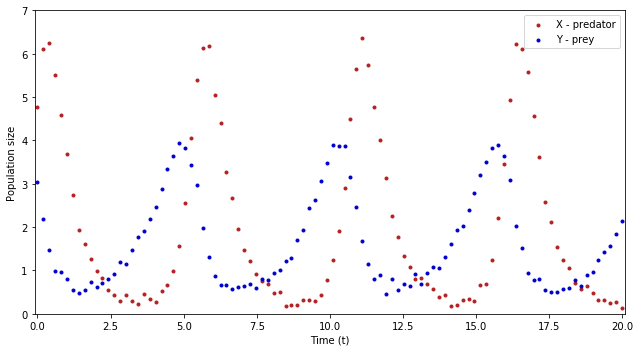

In [10]:
fig,ax = plt.subplots(1, figsize=(9, 5))
ax.scatter(t, data[0], label = 'X - predator', marker = '.', color = 'firebrick')
ax.scatter(t, data[1], label = 'Y - prey', marker = '.', color = 'mediumblue')
ax.set_xlim((-0.1,20.1))
ax.set_ylim((0,7))
ax.set_xlabel('Time (t)')
ax.set_ylabel('Population size')
ax.legend()
fig.show()
fig.tight_layout()     
# plt.savefig(out_path+'/data-given', dpi = 400)

##### cooling schedules

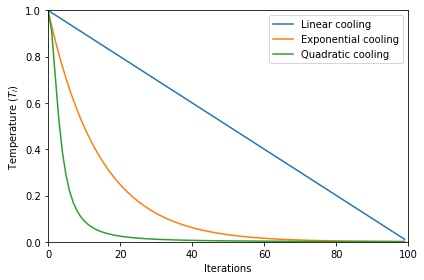

In [13]:
temp_start = 1
temp_end = 10**(-3)
lin, exp, quad = [temp_start,], [temp_start], [temp_start]
rate1 = (temp_start-temp_end)/(100)
rate2 = (temp_end / temp_start) ** (1 / (100 - 1))
alpha = (temp_start / temp_end - 1) / (100) ** 2

for i in range(99):
    lin.append(lin[i] - rate1)
    exp.append(exp[i]*rate2)
    quad.append(temp_start / (1 + alpha * (i+1) ** 2))

fig,ax = plt.subplots(1)
ax.plot(np.arange(100), lin, label='Linear cooling')
ax.plot(np.arange(100), exp, label='Exponential cooling')
ax.plot(np.arange(100), quad, label='Quadratic cooling')
ax.set_xlabel('Iterations')
ax.set_ylabel('Temperature $(T_i)$')
ax.set_xlim((0,100))
ax.set_ylim((0,1))
ax.legend()
fig.show()
fig.tight_layout()     
plt.savefig(out_path+'/coolings-chedules',dpi = 400)

##### hill-climbing

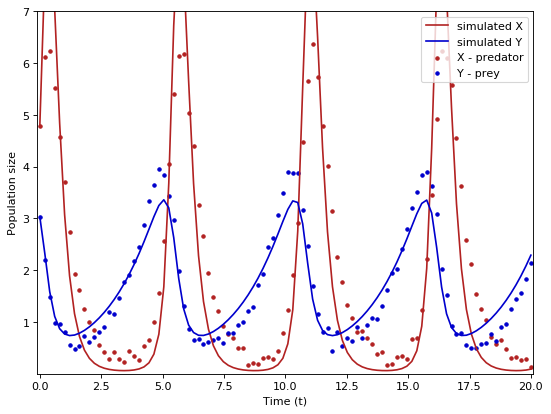

In [55]:
start = np.array([data[0][0],data[1][0]])
df_params = pd.read_csv(data_path+'/RMSE-parameters.csv',index_col=0)
# print(df_params)

figure(figsize=(8, 6), dpi=80)
plt.scatter(t, data[1], label = 'X - predator', marker = '.', color = 'firebrick')
plt.scatter(t, data[0], label = 'Y - prey', marker = '.', color = 'mediumblue')

fit = integrate.odeint(ODEs, start, t, args=tuple(df_params['HC05']))

plt.plot(t,fit[:,1], label='simulated X', color = 'firebrick')
plt.plot(t,fit[:,0], label='simulated Y', color = 'mediumblue')
plt.xlim((-0.1,20.1))
plt.ylim((0,7))
plt.yticks(np.arange(1,8))
plt.legend()
plt.ylabel('Population size')
plt.xlabel('Time (t)')
# plt.show()
plt.savefig(out_path+'/Hill-climbing-0000', dpi = 400)

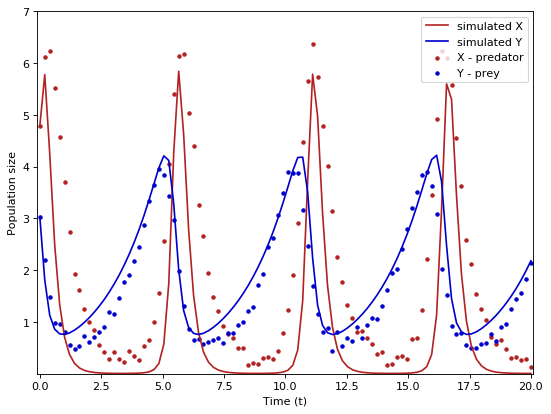

In [56]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(t, data[1], label = 'X - predator', marker = '.', color = 'firebrick')
plt.scatter(t, data[0], label = 'Y - prey', marker = '.', color = 'mediumblue')

fit = integrate.odeint(ODEs, start, t, args=tuple(df_params['HC_start1']))

plt.plot(t,fit[:,1], label='simulated X', color = 'firebrick')
plt.plot(t,fit[:,0], label='simulated Y', color = 'mediumblue')
plt.xlim((-0.1,20.1))
plt.ylim((0,7))
plt.yticks(np.arange(1,8))
plt.legend()
plt.ylabel('Population size')
plt.xlabel('Time (t)')
# plt.show()
plt.savefig(out_path+'/Hill-climbing-1111', dpi = 400)

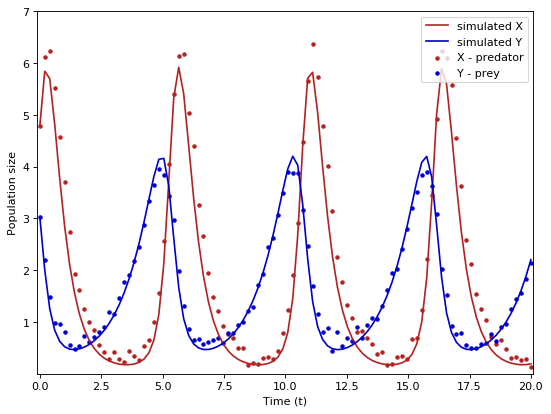

In [57]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(t, data[1], label = 'X - predator', marker = '.', color = 'firebrick')
plt.scatter(t, data[0], label = 'Y - prey', marker = '.', color = 'mediumblue')

fit = integrate.odeint(ODEs, start, t, args=tuple(df_params['HC10']))

plt.plot(t,fit[:,1], label='simulated X', color = 'firebrick')
plt.plot(t,fit[:,0], label='simulated Y', color = 'mediumblue')
plt.xlim((-0.1,20.1))
plt.ylim((0,7))
plt.yticks(np.arange(1,8))
plt.legend()
plt.ylabel('Population size')
plt.xlabel('Time (t)')
# plt.show()
plt.savefig(out_path+'/Hill-climbing-15', dpi = 400)

##### simulated annealing

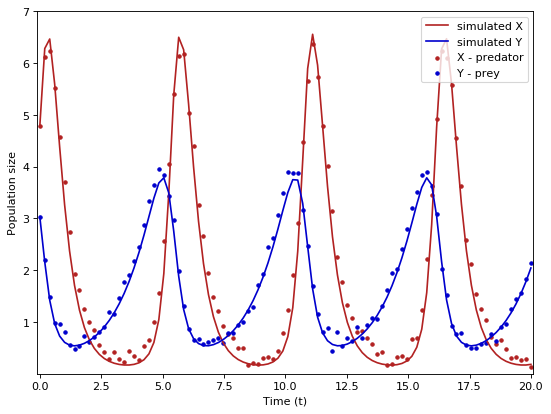

In [58]:
start = np.array([data[0][0],data[1][0]])
df_params = pd.read_csv(data_path+'/RMSE-parameters.csv',index_col=0)
# print(df_params)

figure(figsize=(8, 6), dpi=80)
plt.scatter(t, data[1], label = 'X - predator', marker = '.', color = 'firebrick')
plt.scatter(t, data[0], label = 'Y - prey', marker = '.', color = 'mediumblue')

fit = integrate.odeint(ODEs, start, t, args=tuple(df_params['SA_exp'])) # SA100

plt.plot(t,fit[:,1], label='simulated X', color = 'firebrick')
plt.plot(t,fit[:,0], label='simulated Y', color = 'mediumblue')
plt.xlim((-0.1,20.1))
plt.ylim((0,7))
plt.yticks(np.arange(1,8))
plt.legend()
plt.ylabel('Population size')
plt.xlabel('Time (t)')
# plt.show()
plt.savefig(out_path+'/Sim-Annealing-exp', dpi = 400)

##### sim ann - varying step size

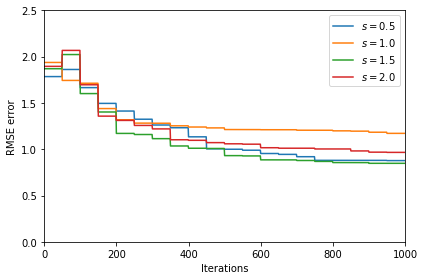

In [14]:
showcolumns = ['SA01','SA025','SA05','SA10']
labels = [r'$s = 0.5$',r'$s = 1.0$',r'$s = 1.5$',r'$s = 2.0$']


df_conv = pd.read_csv(data_path+'/RMSE-conv.csv',index_col=0)
fig,ax = plt.subplots(1)
for i in range(len(showcolumns)):
    ax.plot(np.arange(1000),df_conv[showcolumns[i]], label = labels[i])
    ax.set_xlim((0,1000))
    ax.set_ylabel('RMSE error')
    ax.set_ylim((0,2.5))

ax.set_xlabel('Iterations')
ax.legend(ncol=1,loc='upper right')

fig.show()
fig.tight_layout()
plt.savefig(out_path+'/SimAnn-stepsize', dpi = 400)

##### sim ann - varying markov chain length

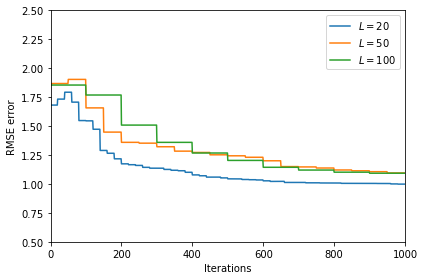

In [15]:
showcolumns = ['SA25','SA40','SA100']
labels = [r'$L = 20$', r'$L = 50$',r'$L = 100$']

df_conv = pd.read_csv(data_path+'/RMSE-conv.csv', index_col=0)
fig,ax = plt.subplots(1)
for i in range(len(showcolumns)):
    ax.plot(np.arange(1000), df_conv[showcolumns[i]], label=labels[i])
    ax.set_xlim((0,1000))
    ax.set_ylabel('RMSE error')
    ax.set_ylim((0.5,2.5))
    ax.set_xlabel('Iterations')

ax.legend(ncol = 1)
fig.show()
fig.tight_layout()
plt.savefig(out_path+'/SimAnn-Ls',dpi = 400)

##### sim ann - varying initial temperature

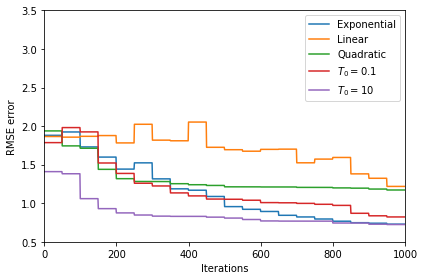

In [16]:
showcolumns = ['SA_exp','SA_lin','SA025','SA_init10','SA_init01']
labels = ['Exponential','Linear','Quadratic',
              r'$T_0 = 0.1$', r'$T_0 = 10$']

df_conv = pd.read_csv(data_path+'/RMSE-conv.csv',index_col=0)
fig,ax = plt.subplots(1)
for i in range(len(showcolumns)):
    ax.plot(np.arange(1000),df_conv[showcolumns[i]],label = labels[i])
    ax.set_xlim((0,1000))
    ax.set_ylabel('RMSE error')
    ax.set_ylim((0.5,3.5))
    ax.set_xlabel('Iterations')
ax.legend(ncol=1)
fig.show()
fig.tight_layout()
plt.savefig(out_path+'/SimAnn-init_temp',dpi = 400)

#### convergence

##### removing parts of data

In [70]:
reps = 10
df = pd.read_csv("predator-prey-data.csv")
# print(df)
t = df.values[:,1]
data_full = (df.values[:,3],df.values[:,2])
data = (df.values[:,3],df.values[:,2])
iterations = 1000
seedr = 777

In [72]:
np.random.seed(seedr)
sizes = np.arange(100, 0, -10)

HC, SA = [], []
HC_std, SA_std = [], []
for s in sizes:
    print('sample size', s)
    index_x = np.sort(np.append(np.random.choice(np.arange(1, 99), s - 2), np.array([0, 99])))
    index_y = np.sort(np.append(np.random.choice(np.arange(1, 99), s - 2), np.array([0, 99])))
    
    indexdata = (index_x, index_y)
    shortdata = (data[0][index_x], data[1][index_y])

    HC_sample, SA_sample = [], []
    for i in range(reps):
        # Hill climber
        print(i)
        RMSE, params, RMSE_list = hillclimbing(errors_ODE, shortdata, t,stepsize = 1, iterations=iterations,indexdata=indexdata,efun=eval)
        error = errors_ODE(params,data,t,efun=eval)
        HC_sample.append(error)

        # Simulated Annealing
        RMSE, params, RMSE_list = simulated_annealing(errors_ODE, shortdata, t, cooling='exponential', iterations=iterations, indexdata=indexdata,
                                             temp_range=(10**0, 10**-3),efun=eval,n_inner=40)
        error = errors_ODE(params, data, t, efun=eval)
        SA_sample.append(RMSE)

    HC.append(np.mean(HC_sample))
    HC_std.append(np.std(HC_sample))
    SA.append(np.mean(SA_sample))
    SA_std.append(np.std(SA_sample))

RMSE_dict = {'HC_mean':HC,'HC_std':HC_std,'SA_mean':SA,'SA_std':SA_std}
pd.DataFrame(RMSE_dict).to_csv('Data/lessdata.csv')

sample size 100
0
1
2
3
4
5
6
7
8
9
sample size 90
0
1
2
3
4
5
6
7
8
9
sample size 80
0
1
2
3
4
5
6
7
8
9
sample size 70
0
1
2
3
4
5
6
7
8
9
sample size 60
0
1
2
3
4
5
6
7
8
9
sample size 50
0
1
2
3
4
5
6
7
8
9
sample size 40
0
1
2
3
4
5
6
7
8
9
sample size 30
0
1
2
3
4
5
6
7
8
9
sample size 20
0
1
2
3
4
5
6
7
8
9
sample size 10
0
1
2
3
4
5
6
7
8
9


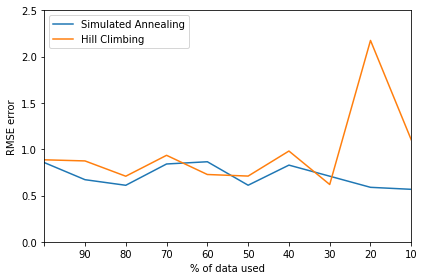

In [10]:
perc = np.arange(1,0,-0.1)
df_less = pd.read_csv(data_path+'/lessdata.csv',index_col=0)

fig,ax = plt.subplots(1)

for less in ['SA_mean', 'HC_mean']:
    print(less)
#     print(df_less['SA_mean'])
    ax.plot(perc, df_less[less])

ax.set_xlim((1,0.1))
ax.set_xticklabels(np.arange(10,100,10))
ax.set_ylim((0,2.5))
ax.set_ylabel('RMSE error')
ax.set_xlabel('% of data used')
ax.legend(['Simulated Annealing','Hill Climbing'])
fig.show()
fig.tight_layout()
plt.savefig(out_path+'/lessdata', dpi = 400)